In [1]:
from pandas import DataFrame
import numpy as np
import pandas
from matplotlib import pyplot as plt

import string 
from scipy.stats import pearsonr
from scipy import stats
import statsmodels.formula.api as smf
import hdbscan
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean

pandas.set_option('display.max_columns', None)
pandas.set_option('display.max_rows', 20)

In [2]:
# Read raw and bi-symmetric log transformed values
df_no_trans = pandas.read_csv("cell-ephyz-raw.csv")
df_all =      pandas.read_csv("cell-ephyz-transformed.csv")

#Set index to be the model ID
df_no_trans.set_index('Unnamed: 0', inplace=True)
df_all.set_index('Unnamed: 0', inplace=True)
df_no_trans.index.name = df_all.index.name = "Cell_ID"

#create default cluster path
df_all["ClusterPath"] = "/"
df_all["Cluster"] = -1
df_all["WasNoise"] = False

In [3]:
prop_names = [
    'AP1Amplitude',
    'AP2Amplitude',
    'AP12AmplitudeDrop',
    'AP12AmplitudeChangePercent',
    'AP1SSAmplitudeChange',  
    
    'AP1WidthHalfHeight',
    'AP2WidthHalfHeight',
    'AP12HalfWidthChangePercent',
    
    'AP1WidthPeakToTrough',
    'AP2WidthPeakToTrough',
    
    'AP1RateOfChangePeakToTrough',
    'AP2RateOfChangePeakToTrough',    
    'AP12RateOfChangePeakToTroughPercentChange',
    
    'AP1AHPDepth',
    'AP2AHPDepth',
    'AP12AHPDepthPercentChange',
    
    'AP1DelayMean',
    'AP2DelayMean',
    
    'AP1DelaySD',
    'AP2DelaySD',
    
    'AP1DelayMeanStrongStim',
    'AP2DelayMeanStrongStim',
    
    'AP1DelaySDStrongStim',
    'AP2DelaySDStrongStim',
    
    'Burst1ISIMean',
    'Burst1ISIMeanStrongStim',
    
    'Burst1ISISD',
    'Burst1ISISDStrongStim',
    
    'InitialAccommodationMean',
    'SSAccommodationMean',
    'AccommodationRateToSS',
    'AccommodationAtSSMean',
    'AccommodationRateMeanAtSS',
    
    
    'ISIMedian',
    'ISICV',
    'ISIBurstMeanChange',
    
    'SpikeRateStrongStim',
    
    'InputResistance',
    
    'SteadyStateAPs',
    
    'FrequencyPassAbove',
    'FrequencyPassBelow',
    
    'RampFirstSpike',
]

In [381]:
def PCA_and_Cluster(parent_path = "/", 
                    hide_noise = False, 
                    remove_noise = False, 
                    k_means = False, 
                    interactive=False,
                    cluster_captions=string.ascii_uppercase,
                    axis_captions=['PC0','PC1','PC2']):
    
    min_cluster_size=10 # IF k_means == False:
    kmeans_n_clusters=6        # IF k_means == True

    #Subselect rows based on selected cluster
    df = df_all[df_all["ClusterPath"].str.startswith(parent_path)]

    # Perform PCA
    from sklearn.preprocessing import StandardScaler
    ss = StandardScaler()
    x = ss.fit_transform(df.loc[:,prop_names].values)
    x = DataFrame(x,columns=prop_names)
    print('start dims', len(prop_names))
    from sklearn.decomposition import PCA
    pca = PCA(svd_solver='full',n_components=0.95)
    principalComponents = pca.fit_transform(x)
    principalDf = DataFrame(data = principalComponents)
    X = principalDf
    X.index = df.index
    print('post-pca dims', len(principalDf.columns))
    print(X.shape[0],'rows')


    #Exploratory cluster analysis of the PCA space - 3D plot, dendrogram, and silhouette analysis

    from matplotlib import pyplot as plt
    #%matplotlib inline
    from mpl_toolkits import mplot3d
    plt.figure(figsize=(15, 7))  
    plt.axes(projection='3d')
    plt.plot(X[0],X[1], X[2],'bo')
    plt.show()

    print(X.shape[0],'items')

    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import numpy as np

    range_n_clusters = range(2, 8)

    clusters = []
    widths = []
    for n_clusters in range_n_clusters:
        from sklearn.cluster import AgglomerativeClustering
        #clusterer = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')  
        clusterer = KMeans(n_clusters=n_clusters)  
        cluster_labels = clusterer.fit_predict(X)

        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)

        clusters.append(n_clusters)
        widths.append(silhouette_avg)

    plt.plot(clusters, widths)
    plt.show()

    # Find the properties that are most highly correlated with the first 3 PCA components

    %matplotlib inline
    i=0
    comp_names = []
    for i in range(3):

        prop_r = np.array([stats.pearsonr(X[i],df[col])[0] if stats.pearsonr(X[i],df[col])[1] < 0.001 else 0 for col in df.columns[:-3]])
        inds = (-np.abs(prop_r)).argsort()
    #     plt.plot(range(len(pca.components_[0])), pca.components_[i][inds])
    #     plt.show()
        print(np.array(prop_names)[inds][:5])
        print(prop_r[inds][:5])

        name = ""
        for f in range(3):
            name += ("-" if prop_r[inds][f] < 0 else "+") + prop_names[inds[f]]
        comp_names.append(name)
        print(name)
        print("         -----            ")
    

    if interactive:
        %matplotlib notebook
        %matplotlib notebook


    # 3D plot of clusters in PCA space
    X_w_noise = X.copy()
    X_w_noise["Cluster"] = -1
    X_w_noise["WasNoise"] = False

    if remove_noise:
        cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
        cluster.fit_predict(X)
        X = X[cluster.labels_ != -1]

    if k_means:
        cluster = KMeans(n_clusters=kmeans_n_clusters,random_state=1)
        cluster.fit_predict(X)

    else:
        cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
        cluster.fit_predict(X)

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    if hide_noise:
        ax.scatter(
            X[cluster.labels_ != -1][0],
            X[cluster.labels_ != -1][1], 
            X[cluster.labels_ != -1][2], depthshade=False,marker='o', 
            c=cluster.labels_[cluster.labels_ != -1], 
            cmap='rainbow')

    else:
        ax.scatter(
            X[0],
            X[1], 
            X[2], depthshade=False,marker='o', 
            c=cluster.labels_, 
            cmap='rainbow')

    ax.set_xlabel(axis_captions[0])
    ax.set_ylabel(axis_captions[1])
    ax.set_zlabel(axis_captions[2])

    plt.tight_layout()

    centers = []

    if k_means:
        centers = cluster.cluster_centers_
    else:
        labels = np.unique(cluster.labels_) if not hide_noise else np.unique(cluster.labels_[cluster.labels_ != -1])

        for l in labels:
            X_label = X[cluster.labels_ == l]
            center = [np.mean(X_label[c]) for c in range(X.shape[1])]
            centers.append(center)

    pca_centers = centers
            
    # Show clusters as letters in the plot
    for i, center in enumerate(centers):
        ax.text(center[0],center[1],center[2],cluster_captions[i],size=20)

    plt.show()
    
    for key in locals().keys():
        globals()[key] = locals()[key]

    import collections
    print(collections.Counter(cluster.labels_))

    # Print cluster summary stats
    for c, center in enumerate(centers):
        dist = np.apply_along_axis(euclidean, 1, X, center)
        dist_sort_is = dist.argsort()
        from pprint import pprint as pp

        pp({"cluster": c, 
            "cells": X.iloc[dist_sort_is].index[:5], 
            "sd":["{:12.2f}".format(np.std(X.iloc[np.where(cluster.labels_ == c)][pc])) for pc in range(3)],
            "center":["{:12.2f}".format(c) for c in center[0:3]],
           })

    # 3D plot of clusters in RAW feature space
    source_df = df_no_trans.ix[X.index]

    display_props = ["ISIMedian","AccommodationAtSSMean","AP1DelayMeanStrongStim"]
    #display_props = ["AP1DelayMeanStrongStim","ISIMedian","AccommodationAtSSMean"]

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(
        source_df[display_props[0]],
        source_df[display_props[1]], 
        source_df[display_props[2]], 
        depthshade=True,
        marker='o', 
        c=cluster.labels_, 
        cmap='rainbow')

    ax.set_xlabel(display_props[0])
    ax.set_ylabel(display_props[1])
    ax.set_zlabel(display_props[2])

    plt.tight_layout()

    centers = []
    sds = []

    labels = np.unique(cluster.labels_)

    print(display_props)

    for i, l in enumerate(labels):
        X_label = source_df[cluster.labels_ == l]
        center = [np.mean(X_label[prop]) for prop in display_props]
        centers.append(center)

        sd = [np.std(X_label[prop]) for prop in display_props]
        sds.append(sd)

        ax.text(center[0],center[1],center[2],cluster_captions[i],size=20)

        print(cluster_captions[i],["{:0.2f}+/-{:0.2f}".format(centers[i][c],sds[i][c]) for c,_ in enumerate(center)])

        reg = smf.ols('AP1DelayMeanStrongStim~ISIMedian',data=X_label).fit()
        print('reg isi v delay params p-s r', reg._results.params, reg._results.pvalues, reg._results.rsquared_adj)

        reg = smf.ols('AP1DelayMeanStrongStim~AccommodationAtSSMean',data=X_label).fit()
        print('reg accom v delay params p-s r', reg._results.params, reg._results.pvalues, reg._results.rsquared_adj)
        
        print("delay v accom",stats.pearsonr(X_label["AP1DelayMeanStrongStim"],X_label["AccommodationAtSSMean"]))
        print("delay v isi",stats.pearsonr(X_label["AP1DelayMeanStrongStim"],X_label["ISIMedian"]))


    plt.show()        

    #%matplotlib inline


    # Set cluster ids in the transformed DataFrame
    X["Cluster"] = cluster.labels_

    # Set cluster in the DF that also has any noise rows
    for label in X.index:
        X_w_noise.at[label, "Cluster"] = X.at[label, "Cluster"]    

    # Assign noise models to the cluster with the closest center
    noise_models = X_w_noise[X_w_noise["Cluster"] == -1].index
    for model in noise_models:    
        #find the closest pca space cluster center
        dist = np.apply_along_axis(euclidean, 1, pca_centers, X_w_noise.ix[model][:-2])
        dist_sort_is = dist.argsort()
        X_w_noise.at[model, "Cluster"] = dist_sort_is[0] #[0] stores the closest cluster ID
        X_w_noise.at[model, "WasNoise"] = True

    df["Cluster"] = X_w_noise["Cluster"]
    df["WasNoise"] = X_w_noise["WasNoise"]
    df["ClusterPath"] = parent_path + df["Cluster"].map(str) + "/"
    

    for label in df.index:
        df_all.at[label, "ClusterPath"] = df.at[label, "ClusterPath"]
        df_all.at[label, "Cluster"] = df.at[label, "Cluster"]
        df_all.at[label, "WasNoise"] = df.at[label, "WasNoise"]

    # Sanity checks
    print('current subset clusters',np.unique(df["ClusterPath"]))
    print('all clusters',np.unique(df_all["ClusterPath"]))
    


('start dims', 42)
('post-pca dims', 21)
(1222, 'rows')


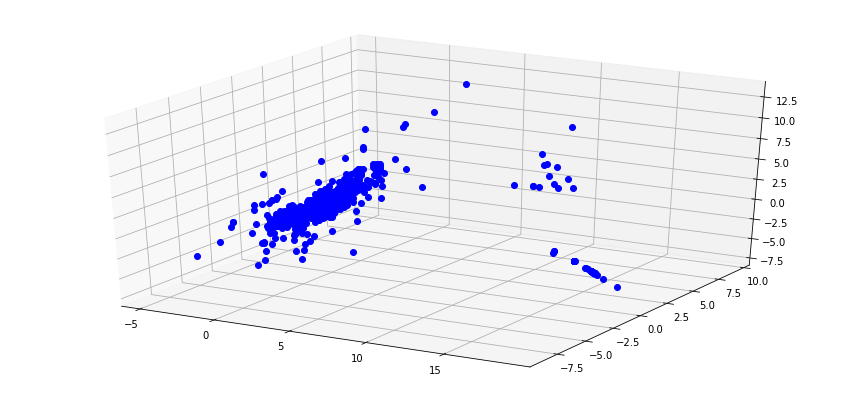

(1222, 'items')
('For n_clusters =', 2, 'The average silhouette_score is :', 0.6499840733994655)
('For n_clusters =', 3, 'The average silhouette_score is :', 0.18939815027158005)
('For n_clusters =', 4, 'The average silhouette_score is :', 0.19928352125158924)
('For n_clusters =', 5, 'The average silhouette_score is :', 0.21219722686832065)
('For n_clusters =', 6, 'The average silhouette_score is :', 0.22440389814583486)
('For n_clusters =', 7, 'The average silhouette_score is :', 0.23022719028895047)


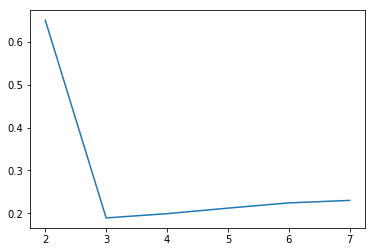

['AP2DelayMeanStrongStim' 'Burst1ISIMeanStrongStim' 'AP2DelayMean'
 'AP1DelayMeanStrongStim' 'Burst1ISIMean']
[0.91759908 0.89644029 0.87071641 0.8622165  0.85987239]
+AP2DelayMeanStrongStim+Burst1ISIMeanStrongStim+AP2DelayMean
         -----            
['AP1SSAmplitudeChange' 'AP12AmplitudeDrop' 'AP12AmplitudeChangePercent'
 'InitialAccommodationMean' 'SSAccommodationMean']
[ 0.75331245  0.72497662 -0.7140355  -0.70496003 -0.67801122]
+AP1SSAmplitudeChange+AP12AmplitudeDrop-AP12AmplitudeChangePercent
         -----            
['AP1WidthPeakToTrough' 'AP2WidthPeakToTrough' 'AP1WidthHalfHeight'
 'AP2WidthHalfHeight' 'InitialAccommodationMean']
[ 0.76975222  0.68104314  0.47631639  0.4505576  -0.3703289 ]
+AP1WidthPeakToTrough+AP2WidthPeakToTrough+AP1WidthHalfHeight
         -----            


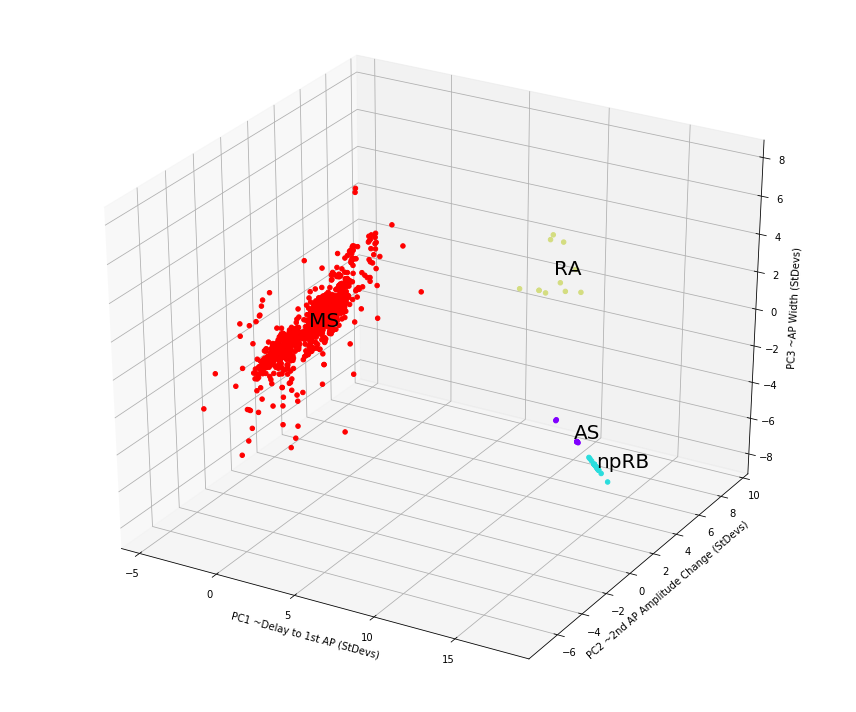

Counter({3: 1156, 1: 26, -1: 17, 0: 12, 2: 11})
{'cells': Index([u'NMLCL001491', u'NMLCL001540', u'NMLCL001505', u'NMLCL001428',
       u'NMLCL001472'],
      dtype='object', name=u'Cell_ID'),
 'center': ['       15.73', '        0.13', '       -2.67'],
 'cluster': 0,
 'sd': ['        0.43', '        0.09', '        0.38']}
{'cells': Index([u'NMLCL001588', u'NMLCL001564', u'NMLCL001579', u'NMLCL001565',
       u'NMLCL001570'],
      dtype='object', name=u'Cell_ID'),
 'center': ['       17.13', '        0.16', '       -3.92'],
 'cluster': 1,
 'sd': ['        0.22', '        0.00', '        0.20']}
{'cells': Index([u'NMLCL001126', u'NMLCL001493', u'NMLCL001410', u'NMLCL001453',
       u'NMLCL001459'],
      dtype='object', name=u'Cell_ID'),
 'center': ['        8.13', '        8.55', '        0.55'],
 'cluster': 2,
 'sd': ['        1.26', '        0.49', '        1.53']}
{'cells': Index([u'NMLCL000355', u'NMLCL000392', u'NMLCL000776', u'NMLCL000316',
       u'NMLCL000372'],
      dtype='

IndexError: list index out of range

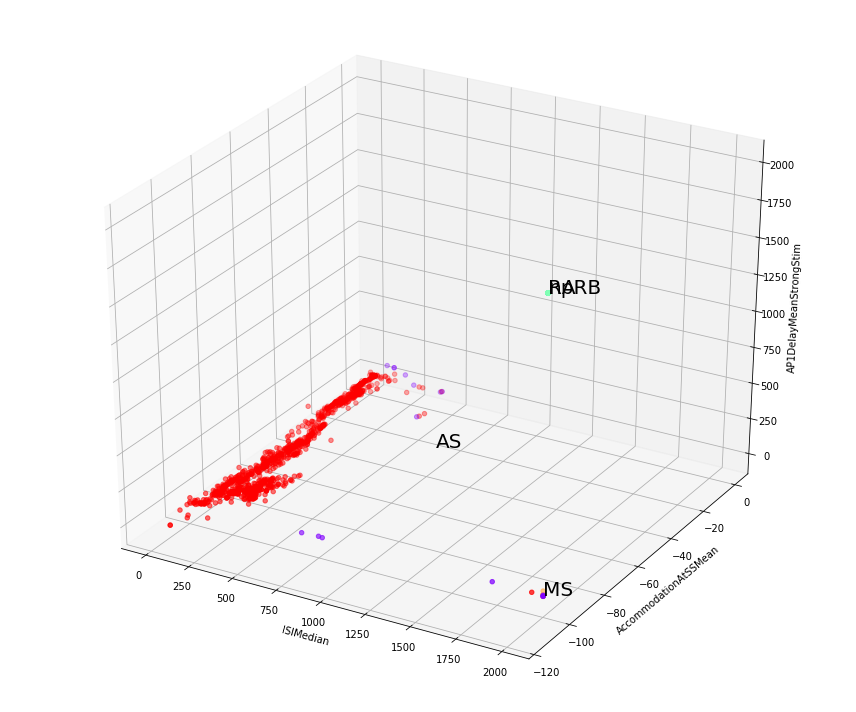

In [382]:
PCA_and_Cluster(parent_path = "/", 
                hide_noise = True, 
                remove_noise = False, 
                k_means = False, 
                interactive=False,
                cluster_captions=['AS','npRB','RA','MS'],
                axis_captions=['PC1 ~Delay to 1st AP (StDevs)', 'PC2 ~2nd AP Amplitude Change (StDevs)', 'PC3 ~AP Width (StDevs)'])

('start dims', 42)
('post-pca dims', 21)
(1168, 'rows')


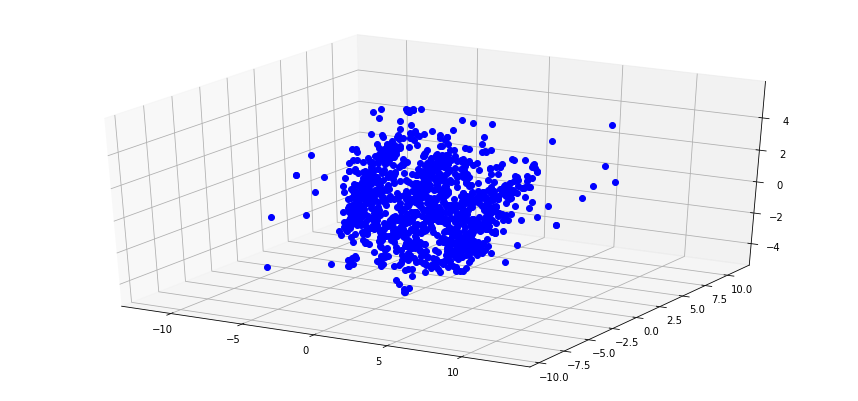

(1168, 'items')
('For n_clusters =', 2, 'The average silhouette_score is :', 0.19069777628284976)
('For n_clusters =', 3, 'The average silhouette_score is :', 0.17134603021492903)
('For n_clusters =', 4, 'The average silhouette_score is :', 0.1863799636442665)
('For n_clusters =', 5, 'The average silhouette_score is :', 0.19542491737546613)
('For n_clusters =', 6, 'The average silhouette_score is :', 0.16971962961015086)
('For n_clusters =', 7, 'The average silhouette_score is :', 0.17445806564369798)


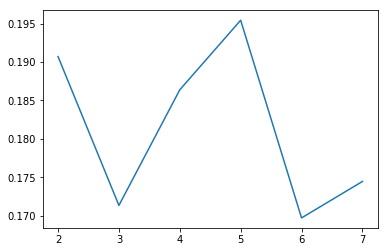

['AP2DelayMean' 'AP2DelayMeanStrongStim' 'AP1DelayMean'
 'AP1DelayMeanStrongStim' 'Burst1ISIMean']
[0.90394287 0.88015605 0.85732465 0.83011132 0.78499595]
+AP2DelayMean+AP2DelayMeanStrongStim+AP1DelayMean
         -----            
['InitialAccommodationMean' 'SSAccommodationMean' 'ISICV'
 'AccommodationAtSSMean' 'AccommodationRateToSS']
[0.80858072 0.79691933 0.78531481 0.77307981 0.68983649]
+InitialAccommodationMean+SSAccommodationMean+ISICV
         -----            
['AP2RateOfChangePeakToTrough' 'AP2WidthPeakToTrough'
 'AP1RateOfChangePeakToTrough' 'AP1AHPDepth' 'AP1WidthPeakToTrough']
[ 0.64393864  0.61495084  0.56468235 -0.55856527  0.55300369]
+AP2RateOfChangePeakToTrough+AP2WidthPeakToTrough+AP1RateOfChangePeakToTrough
         -----            


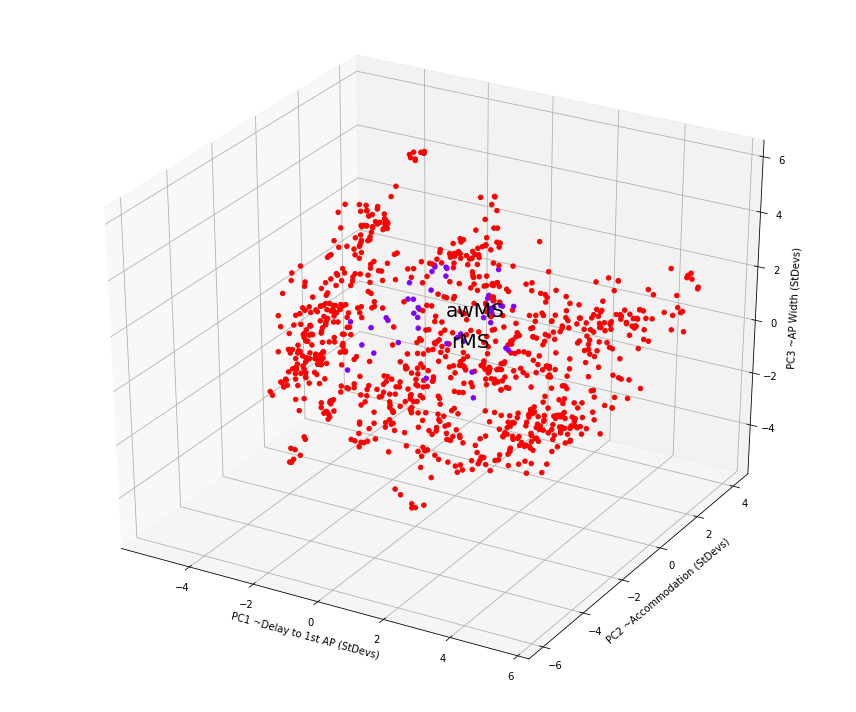

Counter({1: 912, 0: 46, -1: 1})
{'cells': Index([u'NMLCL000670', u'NMLCL000644', u'NMLCL000681', u'NMLCL000643',
       u'NMLCL000678'],
      dtype='object', name=u'Cell_ID'),
 'center': ['        2.18', '       -3.99', '        3.68'],
 'cluster': 0,
 'sd': ['        0.93', '        1.03', '        1.04']}
{'cells': Index([u'NMLCL000776', u'NMLCL000392', u'NMLCL000329', u'NMLCL000372',
       u'NMLCL000769'],
      dtype='object', name=u'Cell_ID'),
 'center': ['       -0.22', '        0.14', '       -0.37'],
 'cluster': 1,
 'sd': ['        2.69', '        1.92', '        1.82']}
['ISIMedian', 'AccommodationAtSSMean', 'AP1DelayMeanStrongStim']
('awMS', ['310.67+/-0.00', '-76.61+/-0.00', '14.64+/-0.00'])
('reg isi v delay params p-s r', array([0.00015168, 0.04712347]), array([nan, nan]), nan)
('reg accom v delay params p-s r', array([ 0.00249416, -0.19107132]), array([nan, nan]), nan)
('delay v accom', (nan, nan))
('delay v isi', (nan, nan))
('rMS', ['227.66+/-45.55', '-76.38+/-13.69',

IndexError: list index out of range

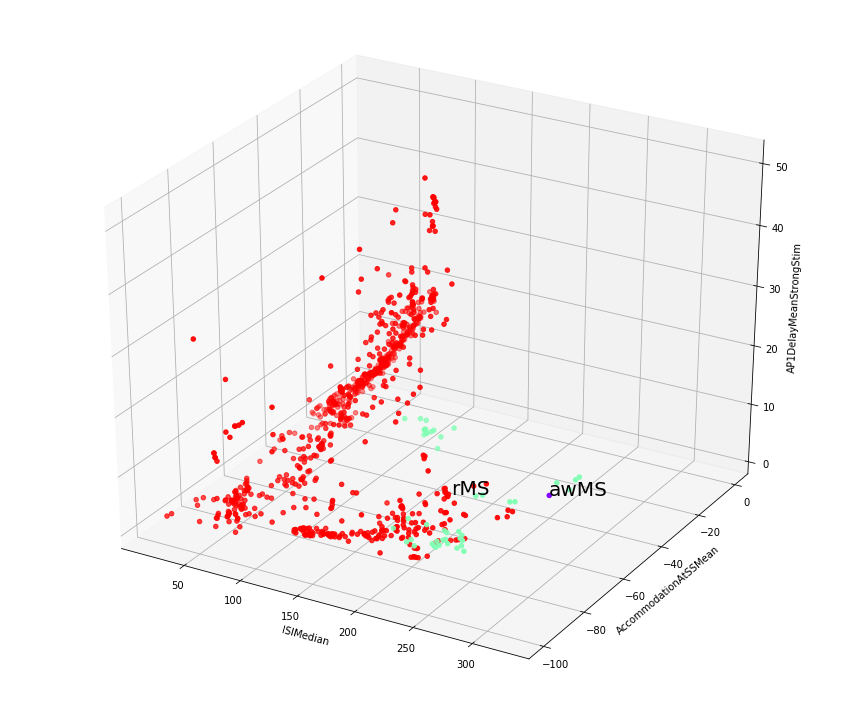

In [383]:
PCA_and_Cluster(parent_path = "/3/", 
                hide_noise = True, 
                remove_noise = True, 
                k_means = False, 
                interactive=False,
                cluster_captions=['awMS','rMS'],
                axis_captions=['PC1 ~Delay to 1st AP (StDevs)', 'PC2 ~Accommodation (StDevs)', 'PC3 ~AP Width (StDevs)'])

In [254]:
%matplotlib notebook
%matplotlib notebook

('start dims', 42)
('post-pca dims', 20)
(1076, 'rows')


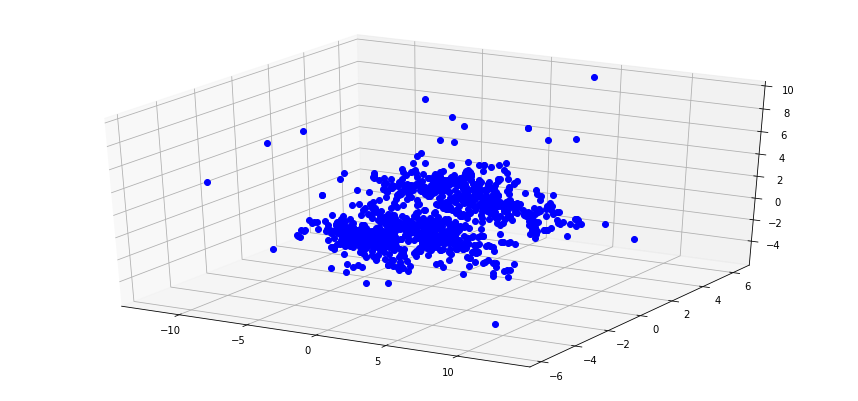

(1076, 'items')
('For n_clusters =', 2, 'The average silhouette_score is :', 0.2051441444792483)
('For n_clusters =', 3, 'The average silhouette_score is :', 0.19136779732255219)
('For n_clusters =', 4, 'The average silhouette_score is :', 0.199215856149146)
('For n_clusters =', 5, 'The average silhouette_score is :', 0.16936054873475095)
('For n_clusters =', 6, 'The average silhouette_score is :', 0.1654787103802055)
('For n_clusters =', 7, 'The average silhouette_score is :', 0.19698324639127238)


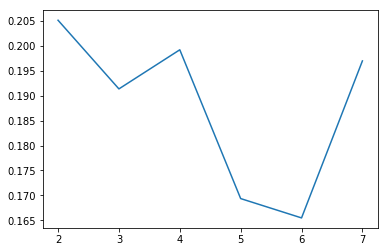

['AP2DelayMean' 'AP2DelayMeanStrongStim' 'AP1DelayMean'
 'AP1DelayMeanStrongStim' 'Burst1ISIMeanStrongStim']
[0.89152176 0.87919688 0.85868644 0.84675867 0.76240562]
+AP2DelayMean+AP2DelayMeanStrongStim+AP1DelayMean
         -----            
['SSAccommodationMean' 'ISIMedian' 'InitialAccommodationMean' 'ISICV'
 'AccommodationAtSSMean']
[ 0.76892819 -0.76026502  0.75897154  0.7284442   0.68583733]
+SSAccommodationMean-ISIMedian+InitialAccommodationMean
         -----            
['AP2RateOfChangePeakToTrough' 'AP1RateOfChangePeakToTrough' 'AP1AHPDepth'
 'AP2WidthPeakToTrough' 'AP2AHPDepth']
[-0.57389963 -0.52798801  0.49778955 -0.48521772  0.48106379]
-AP2RateOfChangePeakToTrough-AP1RateOfChangePeakToTrough+AP1AHPDepth
         -----            


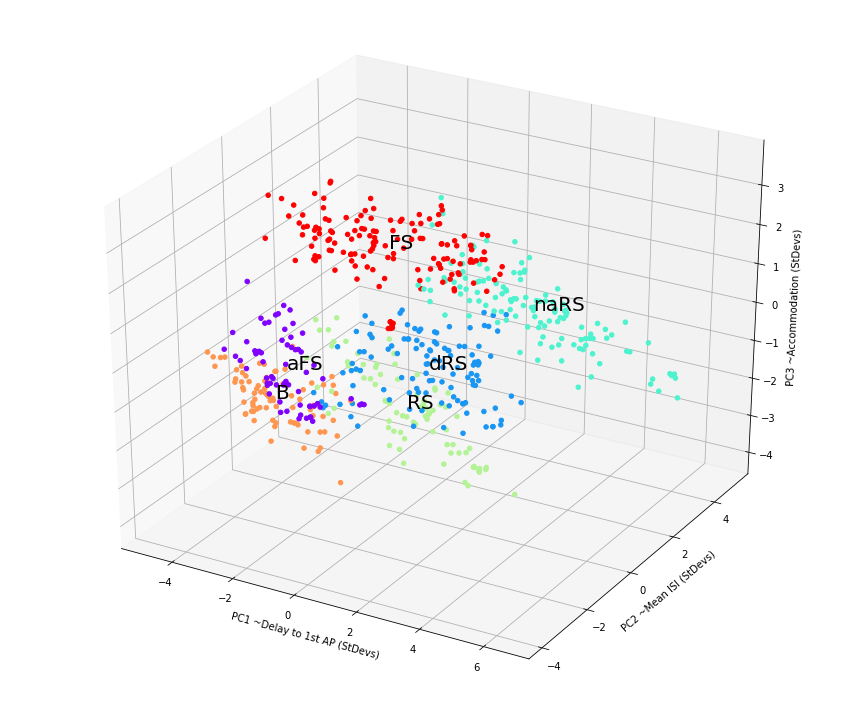

Counter({5: 144, 2: 125, 1: 116, 3: 83, 4: 82, 0: 66})
{'cells': Index([u'NMLCL000728', u'NMLCL000732', u'NMLCL000735', u'NMLCL000711',
       u'NMLCL000742'],
      dtype='object', name=u'Cell_ID'),
 'center': ['       -3.55', '       -0.25', '       -1.35'],
 'cluster': 0,
 'sd': ['        0.54', '        0.88', '        1.01']}
{'cells': Index([u'NMLCL000468', u'NMLCL000616', u'NMLCL000626', u'NMLCL000580',
       u'NMLCL000537'],
      dtype='object', name=u'Cell_ID'),
 'center': ['        2.63', '       -2.30', '        0.74'],
 'cluster': 1,
 'sd': ['        1.08', '        0.72', '        0.82']}
{'cells': Index([u'NMLCL000829', u'NMLCL000881', u'NMLCL000794', u'NMLCL000793',
       u'NMLCL000798'],
      dtype='object', name=u'Cell_ID'),
 'center': ['        3.15', '        1.46', '        0.76'],
 'cluster': 2,
 'sd': ['        1.46', '        0.89', '        1.02']}
{'cells': Index([u'NMLCL000314', u'NMLCL000307', u'NMLCL000395', u'NMLCL000276',
       u'NMLCL000311'],
      

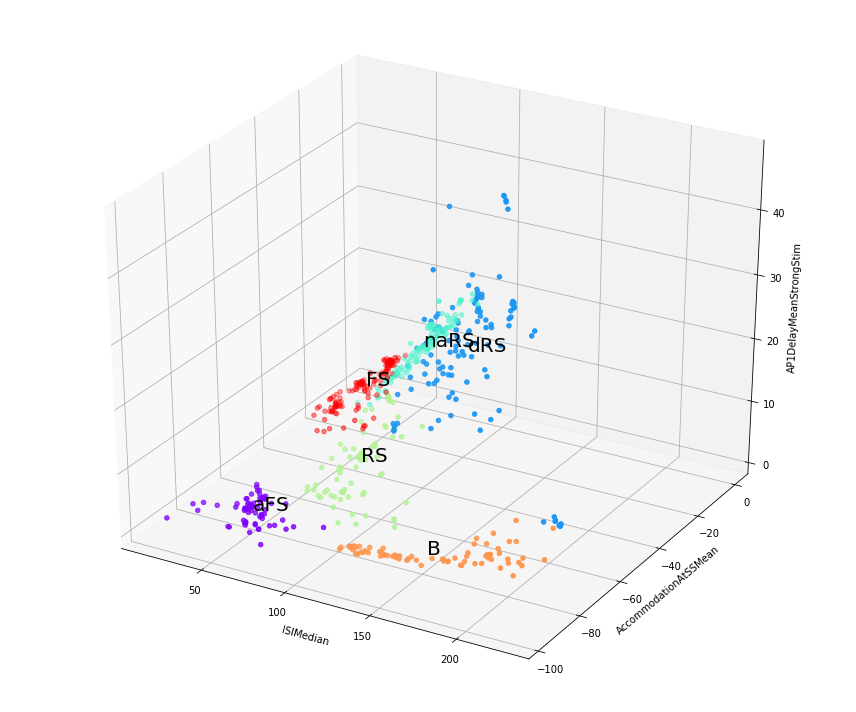

('current subset clusters', array(['/3/1/0/', '/3/1/1/', '/3/1/2/', '/3/1/3/', '/3/1/4/', '/3/1/5/'],
      dtype=object))
('all clusters', array(['/0/', '/1/', '/2/', '/3/0/', '/3/1/0/', '/3/1/1/', '/3/1/2/',
       '/3/1/3/', '/3/1/4/', '/3/1/5/'], dtype=object))


In [384]:
PCA_and_Cluster(parent_path = "/3/1/", 
                hide_noise = False, 
                remove_noise = True, 
                k_means = True, 
                interactive=False,
                cluster_captions=['aFS','dRS','naRS','RS','B','FS'],
                axis_captions=['PC1 ~Delay to 1st AP (StDevs)', 'PC2 ~Mean ISI (StDevs)', 'PC3 ~Accommodation (StDevs)'])

In [398]:
%matplotlib inline

In [407]:
%matplotlib notebook
%matplotlib notebook

<IPython.core.display.Javascript object>


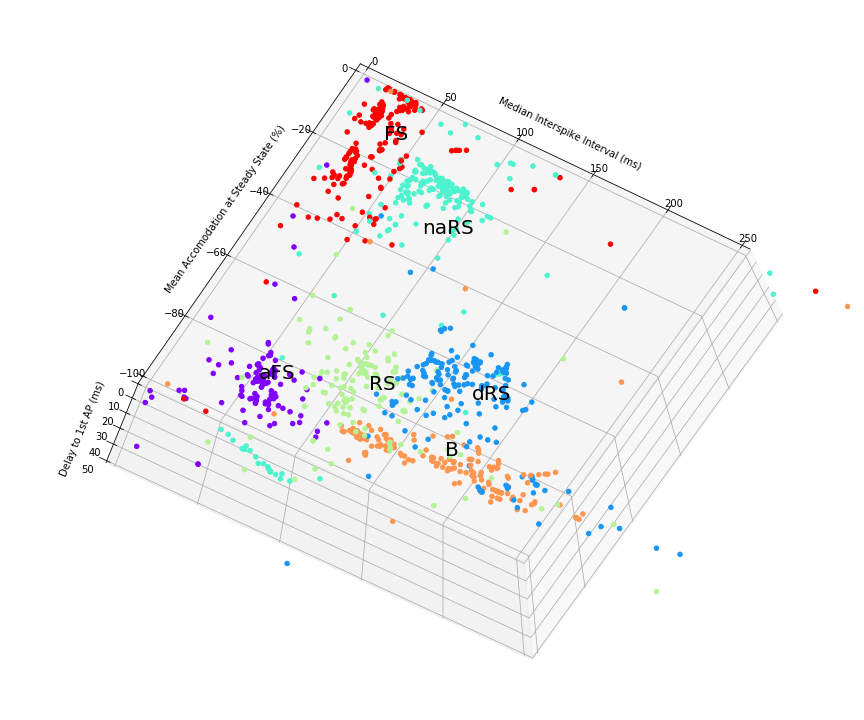

In [412]:
# 3D plot of clusters in RAW feature space
source_df = df_all[df_all["ClusterPath"].str.startswith("/3/1/")]
#source_df = source_df[source_df["WasNoise"] == False]
clusters = source_df["Cluster"]

source_df = df_no_trans.ix[source_df.index]

cluster_captions=['aFS','dRS','naRS','RS','B','FS']
display_props = ["ISIMedian","AccommodationAtSSMean","AP1DelayMeanStrongStim"]
#display_props = ["AP1DelayMeanStrongStim","ISIMedian","AccommodationAtSSMean"]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    source_df[display_props[0]],
    source_df[display_props[1]], 
    source_df[display_props[2]], 
    depthshade=False,
    marker='o', 
    c=clusters, 
    cmap='rainbow')

ax.set_xlabel("Median Interspike Interval (ms)")
ax.set_ylabel("Mean Accomodation at Steady State (%)")
ax.set_zlabel("Delay to 1st AP (ms)")

ax.set_xlim([0,250])
ax.set_ylim([-100,0])
ax.set_zlim([0,50])

labels = np.unique(clusters)

for i, l in enumerate(labels):
    X_label = source_df[clusters == l]
    center = [np.mean(X_label[prop]) for prop in display_props]
    ax.text(center[0],center[1],center[2],cluster_captions[i],size=20)

plt.tight_layout()

plt.show() 

In [345]:
def plot_tetrahedron_projection(dim_x = 1, dim_y = 2, invert_x=False):
    %matplotlib inline

    ax_labels = ["Median Interspike Interval (ms)", 
                 "Mean Accomodation at Steady State (%)", 
                 "Delay to 1st AP (ms)"]

    fig = plt.figure()#figsize=(12, 10))
    ax = fig.add_subplot(111)

    ax.scatter(
        source_df[display_props[dim_x]],
        source_df[display_props[dim_y]], 
        marker='o', 
        c=clusters, 
        cmap='rainbow')

    ax.set_xlabel(ax_labels[dim_x])
    ax.set_ylabel(ax_labels[dim_y])

    labels = np.unique(clusters)

    for i, l in enumerate(labels):
        X_label = source_df[clusters == l]
        center = [np.mean(X_label[prop]) for prop in display_props]
        ax.text(center[dim_x],center[dim_y],cluster_captions[i],size=12,backgroundcolor="#2E917A",color="w",bbox={'linewidth':0,'alpha':0.75})
        

    plt.tight_layout()

    if invert_x:
        plt.gca().invert_xaxis()

    plt.show() 

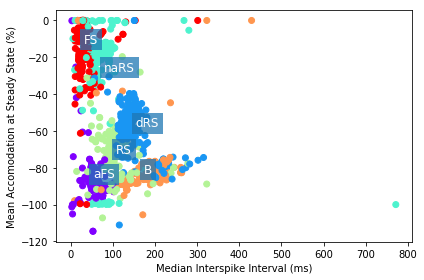

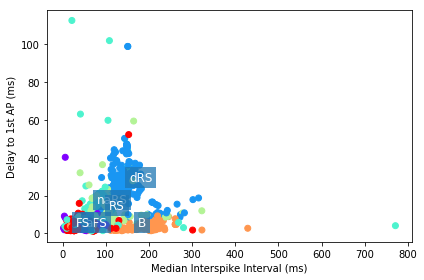

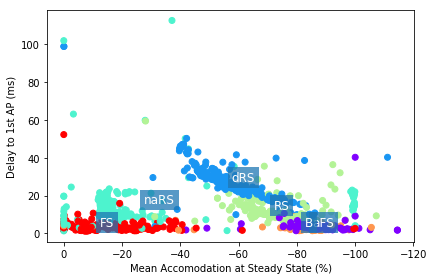

In [368]:
plot_tetrahedron_projection(0,1)
plot_tetrahedron_projection(0,2)
plot_tetrahedron_projection(1,2,True)

In [167]:
#CLUSTER naRS RELATIONSHIP EXAMPLES
#display_props = ["ISIMedian","AccommodationAtSSMean","AP1DelayMeanStrongStim"]

min_x = source_df.ix[np.where(clusters == 1)]["AccommodationAtSSMean"].min()
print(source_df[source_df["AccommodationAtSSMean"] == min_x]["AP1DelayMeanStrongStim"])

max_x = source_df.ix[np.where(clusters == 1)]["AccommodationAtSSMean"].max()
print(source_df[source_df["AccommodationAtSSMean"] == max_x]["AP1DelayMeanStrongStim"])

Cell_ID
NMLCL000137    10.44
Name: AP1DelayMeanStrongStim, dtype: float64
Cell_ID
NMLCL000552    44.9
Name: AP1DelayMeanStrongStim, dtype: float64


In [169]:
#CLUSTER dRS RELATIONSHIP EXAMPLES
#display_props = ["ISIMedian","AccommodationAtSSMean","AP1DelayMeanStrongStim"]

min_x = source_df.ix[np.where(clusters == 2)]["ISIMedian"].min()
print(source_df[source_df["ISIMedian"] == min_x]["AP1DelayMeanStrongStim"])

max_x = source_df.ix[np.where(clusters == 2)]["ISIMedian"].max()
print(source_df[source_df["ISIMedian"] == max_x]["AP1DelayMeanStrongStim"])

Cell_ID
NMLCL000905    6.57
Name: AP1DelayMeanStrongStim, dtype: float64
Cell_ID
NMLCL000499    29.47
Name: AP1DelayMeanStrongStim, dtype: float64


In [370]:
from manager import ModelManager
from tables import Cells, Model_Waveforms, Models

import manager
reload(manager)
mgr = ModelManager()
mgr.server.connect()

Connecting to server...
Connecting to MySQL database...


In [371]:
# Update database with cluster assignments
cell_records = list(Cells\
    .select(Cells,Model_Waveforms.Spikes,Models.Name)\
    .join(Model_Waveforms, on=(Cells.Model_ID == Model_Waveforms.Model_id))\
    .join(Models, on=(Cells.Model_ID == Models.Model_ID))\
    .where((Model_Waveforms.Protocol == "STEADY_STATE") & (Model_Waveforms.Variable_Name == "Voltage"))\
    .order_by(Cells.Model_ID)
)
   
for cell_id in df_all.index:
    cell = next(cell for cell in cell_records if cell.Model_ID == cell_id)
    cell.Ephyz_Cluster_ID = df_all.loc[cell_id]["ClusterPath"]
    
with mgr.server.db.atomic():
    for cell_id in df_all.index:
        cell = next(cell for cell in cell_records if cell.Model_ID == cell_id)
        cell.save()
        print(cell_id)
    
    print('saving...')